# Prototyping notebook for future version

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path

# import pyref as rf
import polars as pl
import pyref_rs as rf

In [2]:
directory = Path.home() / "projects/pyref/test/190.0"
data = rf.py_read_experiment(str(directory), "xrr")
print(data)

shape: (170, 10)
┌────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Sample ┆ Beamline   ┆ EPU Polari ┆ Horizontal ┆ … ┆ Raw       ┆ Raw Shape ┆ Lambda    ┆ Q [Å⁻¹]  │
│ Theta  ┆ Energy     ┆ zation     ┆ Exit Slit  ┆   ┆ ---       ┆ ---       ┆ [Å]       ┆ ---      │
│ ---    ┆ ---        ┆ ---        ┆ Size       ┆   ┆ list[u32] ┆ list[u32] ┆ ---       ┆ f64      │
│ f64    ┆ f64        ┆ f64        ┆ ---        ┆   ┆           ┆           ┆ f64       ┆          │
│        ┆            ┆            ┆ f64        ┆   ┆           ┆           ┆           ┆          │
╞════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.0    ┆ 286.7      ┆ 190.0      ┆ 1500.0     ┆ … ┆ [33350,   ┆ [225,     ┆ 43.245273 ┆ 0.0      │
│        ┆            ┆            ┆            ┆   ┆ 33320, …  ┆ 225]      ┆           ┆          │
│        ┆            ┆            ┆            ┆   ┆ 33437]    ┆         

In [39]:
hos = [None] * len(names)
exposure = [None] * len(names)
theta = [0] * len(names)
size = [None] * len(names)
image = [None] * len(names)
izero = [False] * len(names)
stitch = [0] * len(names)

s = 0

for i in range(len(names)):
    file = directory / names[i]
    hdul = fits.open(file)
    hos[i] = round(hdul[0].header["Higher Order Suppressor"], 2)
    exposure[i] = hdul[0].header["EXPOSURE"]
    theta[i] = hdul[0].header["Sample Theta"]
    image[i] = np.asarray(hdul[2].data, dtype=np.uint16).tobytes()
    size[i] = hdul[2].data.shape
    hdul.close()

    # Use the prior file to determine if the image is a stitch or izero
    if theta[i - 1] == theta[i]:
        izero[i] = True
    if theta[i] < theta[i - 1]:
        s += 1
    stitch[i] = s

df = pl.DataFrame(
    {
        "File": names,
        "HOS": hos,
        "Exposure": exposure,
        "Theta": theta,
        "Stitch": stitch,
        "izero": izero,
        "Image": image,
        "Size": size,
    }
)
print(df)

shape: (170, 8)
┌─────────────────────┬─────┬──────────┬────────┬────────┬───────┬────────────────────┬────────────┐
│ File                ┆ HOS ┆ Exposure ┆ Theta  ┆ Stitch ┆ izero ┆ Image              ┆ Size       │
│ ---                 ┆ --- ┆ ---      ┆ ---    ┆ ---    ┆ ---   ┆ ---                ┆ ---        │
│ str                 ┆ f64 ┆ f64      ┆ f64    ┆ i64    ┆ bool  ┆ binary             ┆ list[i64]  │
╞═════════════════════╪═════╪══════════╪════════╪════════╪═══════╪════════════════════╪════════════╡
│ ZnPc82261-00429.fit ┆ 5.6 ┆ 0.1      ┆ 26.636 ┆ 0      ┆ false ┆ b"b\x02?\x026\x02B ┆ [225, 225] │
│ s                   ┆     ┆          ┆        ┆        ┆       ┆ \x02M\x02H\x…      ┆            │
│ ZnPc82261-00470.fit ┆ 5.6 ┆ 10.0     ┆ 43.4   ┆ 0      ┆ false ┆ b"l\x02L\x02>\x02@ ┆ [225, 225] │
│ s                   ┆     ┆          ┆        ┆        ┆       ┆ \x02H\x02A\x…      ┆            │
│ ZnPc82261-00464.fit ┆ 5.6 ┆ 10.0     ┆ 39.2   ┆ 1      ┆ false ┆ b"M\x02M

In [40]:
import matplotlib as mpl

s1 = df
s1_train = s1.filter(pl.col("izero"))

full_ccd = np.array(
    [
        np.frombuffer(i, dtype=np.uint16).reshape(s1["Size"][0])
        for i in s1_train["Image"]
    ]
)
all_images = np.array(
    [np.frombuffer(i, dtype=np.uint16).reshape(s1["Size"][0]) for i in s1["Image"]]
)
# Get noisy images for testing of the same length as full_ccd but with the lowest intensity values
lowest_to_highest = np.argsort([np.max(i) for i in all_images])
noisy_images = all_images[lowest_to_highest][: len(full_ccd)]
print(noisy_images.shape)
# find min an max values for the colorbar
vmin = np.min(noisy_images)
vmax = np.max(noisy_images)
cmp = "terrain"


def timeit(func):
    import time

    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Execution time: {end-start:.2f} seconds")
        return result

    return wrapper


@timeit
def test_on_izero(
    beam_spot_detector: callable, bsd_kwargs: dict = {}, full_ccd=noisy_images
):
    fig, ax = plt.subplots(
        3, len(full_ccd) // 3, figsize=(6.4 * 8, 4.8 * 3.5), tight_layout=True
    )
    ax = ax.flatten()
    fig.suptitle(f"{beam_spot_detector.__name__} on izero images", fontsize=16)
    for i in range(len(full_ccd)):
        try:
            ax[i].imshow(full_ccd[i], cmap=cmp, vmin=vmin, vmax=vmax)
        except:
            break
        try:
            beam_spot = beam_spot_detector(full_ccd[i], **bsd_kwargs)
            ax[i].add_patch(
                plt.Rectangle(
                    (beam_spot[1] - 10, beam_spot[0] - 10),
                    20,
                    20,
                    edgecolor="r",
                    facecolor="none",
                )
            )
            ax[i].axis("off")
        except:
            continue

(2, 225, 225)


In [41]:
from typing import Literal
from skimage import segmentation


def validate_point(image, point, roi):
    avg = np.mean(image)
    if np.abs(image[point] - avg) < 2 * np.std(image):
        raise ValueError("The beam spot is not good.")
    if (
        point[0] < roi
        or point[1] < roi
        or point[0] > image.shape[0] - roi
        or point[1] > image.shape[1] - roi
    ):
        raise ValueError("The beam spot is too close to the edge of the image.")


def bright_pixel(
    image,
    blur_method: Literal["gaussian", "median", "bilateral"] = ...,
    roi=20,
    edge: int | None = None,
):
    """
    Find the beamspot via the brightest pixel.

    Parameters
    ----------
    image : np.ndarray
        The image to analyze.
    blur_method : str, optional
        The method to use to blur the image. Options are 'gaussian', 'median', and
        'bilateral'.
    roi : tuple, optional
        The region of interest to analyze. If None, the roi will be inferred from
        the image.
    """
    # slice off 10 pixels from the edge of the image
    if edge is not None:
        image = image[edge:-edge, edge:-edge]

    print(roi)
    roi += image.shape[0] % roi

    beam_spot = np.unravel_index(np.argmax(image, axis=None), image.shape)
    # Verify if the beam spot is good or not
    validate_point(image, beam_spot, roi)
    return beam_spot


def bp_nn(image, last_point: tuple[int, int], mu=1, roi=20, edge=None):
    if edge is not None:
        image = image[edge:-edge, edge:-edge]

    roi += image.shape[0] % roi
    image = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    image = cv.GaussianBlur(image, (roi, roi), 0)
    image = -np.log(image)
    metric = image - mu * image[last_point[0]][last_point[1]]
    return beam_spot

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [3 3 3 ... 3 3 3]]


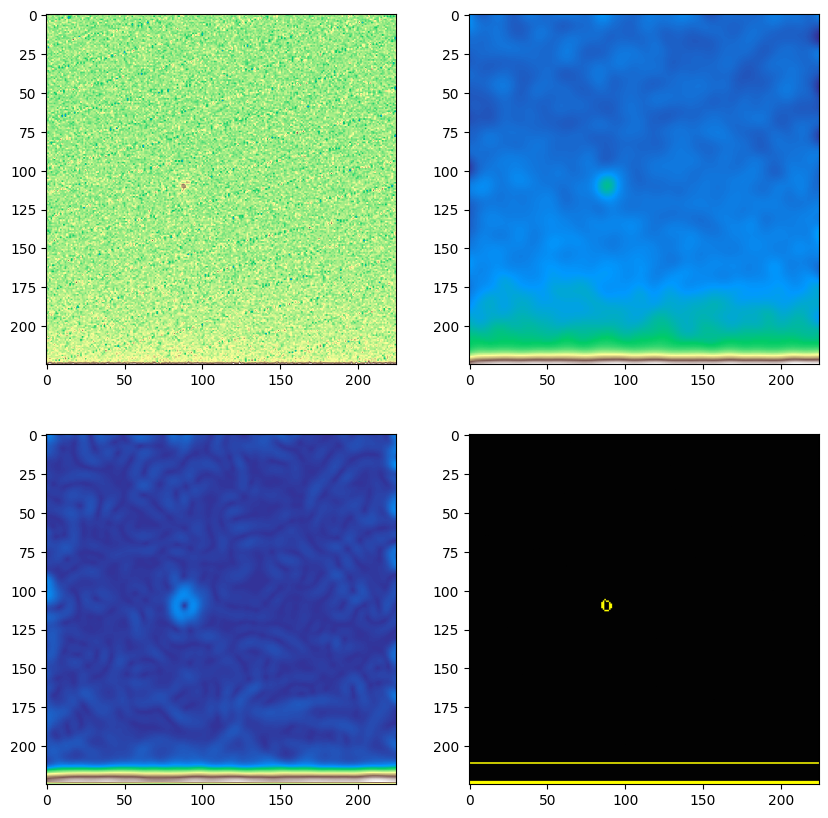

In [42]:
import skimage
from skimage.segmentation import mark_boundaries

test_image = noisy_images[0]
filtered = skimage.filters.gaussian(test_image, sigma=5)
elevation_map = skimage.filters.sobel(filtered)

segmentation = skimage.segmentation.felzenszwalb(elevation_map, min_size=10)
print(segmentation)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(test_image, cmap="terrain")
ax[0, 1].imshow(filtered, cmap="terrain")
ax[1, 0].imshow(elevation_map, cmap="terrain")
ax[1, 1].imshow(mark_boundaries(test_image, segmentation), cmap="terrain")

In [46]:
import numpy as np
from numba import njit, prange
from skimage import measure


@njit(cache=True, nogil=True)
def find_max_index(arr):
    """Find the index of the maximum value in a 2D array."""
    max_value = arr[0, 0]
    x = 0
    y = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i, j] > max_value:
                max_value = arr[i, j]
                x = i
                y = j
    return (x, y)  # Return a tuple instead of a list


@njit(cache=True, nogil=True, parallel=True)
def spec_reflectance(masked, beam_spot, box_size):
    """Calculate the specular reflectance of the image."""
    # Get the coordinates
    beam_x = beam_spot[0]
    beam_y = beam_spot[1]

    # Define the ROI boundaries, ensuring they are within image bounds
    roi_start = max(0, beam_x - box_size)
    roi_end = min(masked.shape[0], beam_x + box_size + 1)
    roj_start = max(0, beam_y - box_size)
    roj_end = min(masked.shape[1], beam_y + box_size + 1)

    # Initialize sums and counts
    direct_beam_sum = 0.0
    direct_beam_count = 0
    bg_weighted_sum = 0.0
    bg_weight_total = 0.0

    # Iterate over all rows
    for i in prange(masked.shape[0]):
        # Iterate over all columns
        for j in range(masked.shape[1]):
            value = masked[i, j]
            if value == 0:
                continue
            if (roi_start <= i < roi_end) and (roj_start <= j < roj_end):
                # Within the direct beam region
                direct_beam_sum += value
                direct_beam_count += 1
            else:
                # Background region
                weight = 1.0 / value
                bg_weighted_sum += value * weight
                bg_weight_total += weight

    # Calculate the means
    if direct_beam_sum == 0:
        return (0.0, 0.0)
    if bg_weight_total == 0:
        return (direct_beam_sum, 0.0)

    bg_mean = bg_weighted_sum / bg_weight_total
    bg_std = np.sqrt(1.0 / bg_weight_total)

    spec_reflectance_value = direct_beam_sum - (bg_mean * direct_beam_count)
    uncertainty = np.sqrt(direct_beam_count) + bg_std
    return (spec_reflectance_value, uncertainty)  # Return a tuple


@njit(cache=True, nogil=True)
def apply_mask(img, mask=None, edge=10):
    """Apply a mask to an image."""
    if mask is not None:
        return mask_edge(img * mask, edge=edge)
    return mask_edge(img, edge=edge)


@njit(cache=True, nogil=True)
def mask_edge(image, edge=10):
    """Mask the edge of the image."""
    masked_image = np.copy(image)
    masked_image[:edge, :] = 0
    masked_image[-edge:, :] = 0
    masked_image[:, :edge] = 0
    masked_image[:, -edge:] = 0
    return masked_image


@njit(cache=True, nogil=True)
def find_beam_from_contours(contours: np.ndarray) -> tuple[int, int]:
    """Find the beam from a list of contours."""
    min_area = np.inf
    min_contour = None
    for contour in contours:
        labeled_contour = measure.label(contour)
        props = measure.regionprops(labeled_contour)
        if not props:
            continue
        area = props[0].area
        if area < min_area:
            min_area = area
            min_contour = contour
    if min_contour is None:
        return 0, 0
    # Get the centroid of the contour
    center = np.mean(min_contour, axis=0)
    center = np.round(center).astype(int)
    return tuple(center)

(110, 88)
Specular reflectance: 1316.87 +/- 21.11


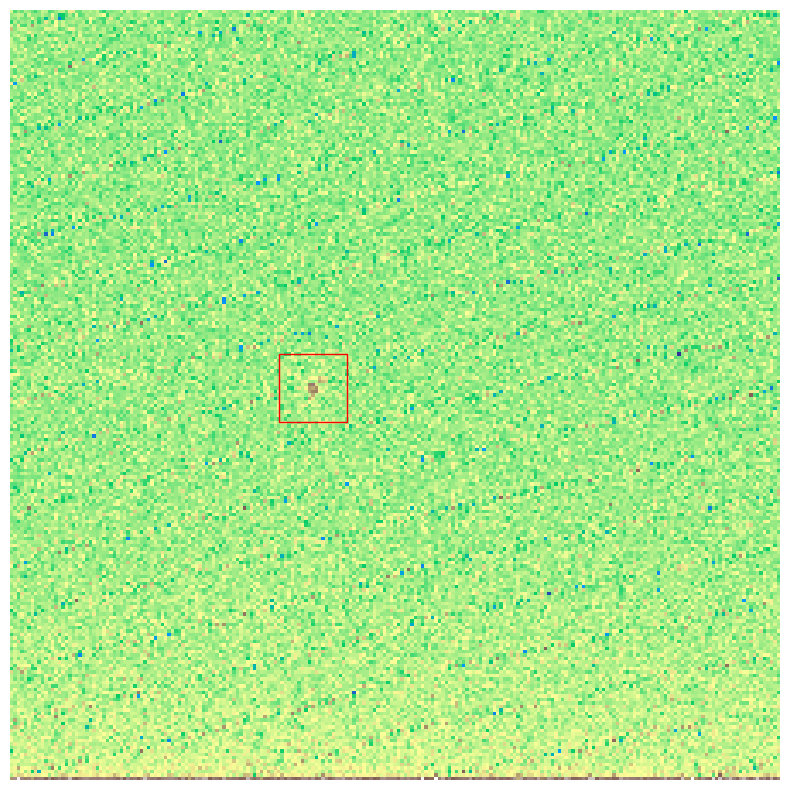

In [47]:
def beamspot(image, radius=5) -> tuple[int, int]:
    """Locate the beam in the image."""
    img = skimage.filters.gaussian(image, sigma=radius)
    beam_spot = find_max_index(img)
    if beam_spot[0] == 0 or beam_spot[1] == 0 or beam_spot[0] == img.shape[0] - 1:
        # Use edge detection to find the beam
        elevation_map = skimage.filters.sobel(img)
        segmentation = skimage.segmentation.felzenszwalb(
            elevation_map, min_size=2 * radius
        )
        # plot contours of the segmentation on the image
        beam_spot = find_beam_from_contours(segmentation)
    return beam_spot  # Should be a tuple


def show_beamspot(ax, img, beam_spot, roi):
    """Show the detected beamspot on the image."""
    ax.imshow(img, cmap="terrain")
    # add dot at the beam spot
    ax.add_patch(
        plt.Rectangle(
            (beam_spot[1] - roi, beam_spot[0] - roi),
            2 * roi,
            2 * roi,
            edgecolor="r",
            facecolor="none",
        )
    )
    ax.axis("off")


roi = 10
# test on the test_image

img = apply_mask(test_image, edge=20)
beam_spot = beamspot(img)
print(beam_spot)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
show_beamspot(ax, test_image, beam_spot, roi)
i = spec_reflectance(test_image, beam_spot, roi)
print(f"Specular reflectance: {i[0]:.2f} +/- {i[1]:.2f}")

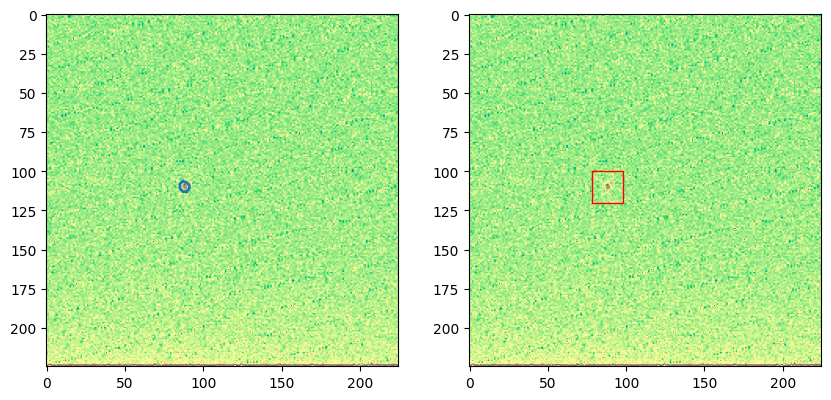

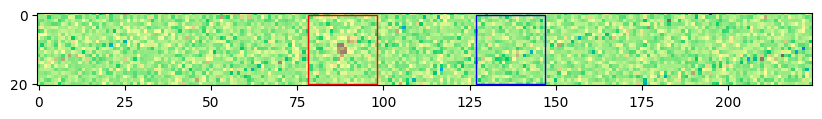

In [22]:
from skimage import measure

contours = measure.find_contours(segmentation, 0)

# Find the contour with the smallest area
min_area = np.inf
min_contour = None
for contour in contours:
    area = measure.regionprops(measure.label(contour))[0].area
    if area < min_area:
        min_area = area
        min_contour = contour

# Find the center of the min area contour
center = np.mean(min_contour, axis=0)
center = np.round(center).astype(int)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(test_image, cmap="terrain")
ax[0].plot(min_contour[:, 1], min_contour[:, 0], linewidth=2)
ax[1].imshow(test_image, cmap="terrain")
# add a square around the center of the contour
ax[1].add_patch(
    plt.Rectangle(
        (center[1] - 10, center[0] - 10), 20, 20, edgecolor="r", facecolor="none"
    )
)
vmin = np.min(test_image)
vmax = np.max(test_image)

sliced = test_image[int(center[0]) - 10 : int(center[0]) + 11, :]
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(sliced, cmap="terrain", vmin=vmin, vmax=vmax)
ax.add_patch(
    plt.Rectangle((center[1] - 10, 0), 20, 20, edgecolor="r", facecolor="none")
)

opposite = test_image.shape[1] - center[1]
ax.add_patch(plt.Rectangle((opposite - 10, 0), 20, 20, edgecolor="b", facecolor="none"))

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(sliced, cmap="terrain", vmin=vmin, vmax=vmax)
ax.add_patch(
    plt.Rectangle((center[1] - 10, 0), 20, 20, edgecolor="r", facecolor="none")
)

# Construct a list [beam_spot, not_beam_spot]
beam_spot = sliced[:, center[1] - 5 : center[1] + 10]
not_beam_spot = np.concatenate(
    (sliced[:, : center[1] - 10].flatten(), sliced[:, center[1] + 10 :].flatten())
)

# Create labels for the pixels
labels = np.array(["beam"] * beam_spot.size + ["not beam"] * not_beam_spot.size)
# Concatenate the intensity values and labels
intensity_values = np.concatenate((beam_spot.flatten(), not_beam_spot.flatten()))

df = pl.DataFrame({"intensity": intensity_values, "labels": labels})

bg = df.filter(pl.col("labels") == "not beam")["intensity"].median()
df_sub = df.with_columns([pl.col("intensity") - bg, pl.col("labels")])
print(bg)
print(df_sub)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.histplot(data=df, x="intensity", hue="labels", bins=50, kde=True, ax=ax[0])
sns.histplot(data=df_sub, x="intensity", hue="labels", bins=50, kde=True, ax=ax[1])

ModuleNotFoundError: No module named 'seaborn'

NameError: name 'bg' is not defined

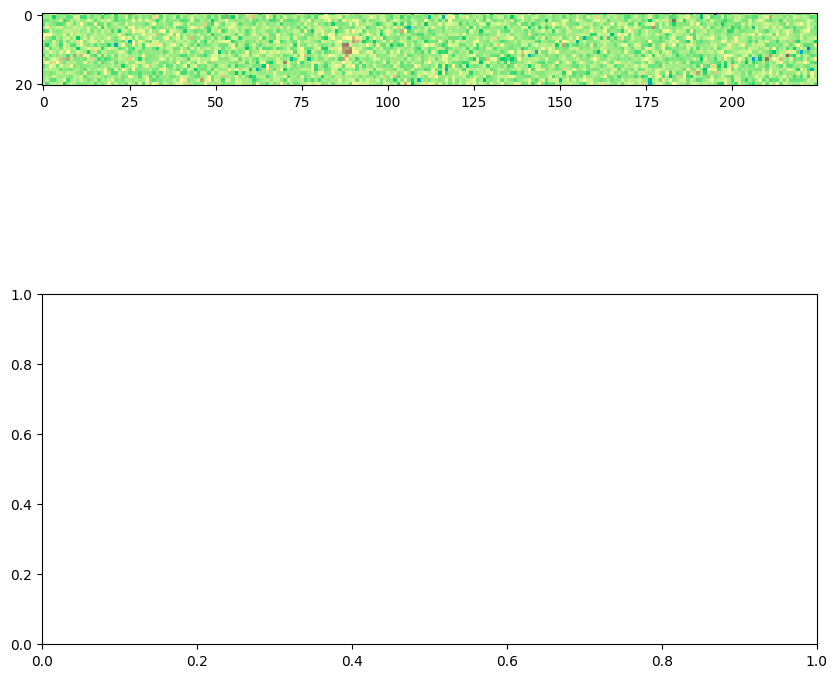

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
ax[0].imshow(sliced, cmap="terrain", vmin=vmin, vmax=vmax)
ax[1].imshow(sliced - bg, cmap="terrain", vmin=vmin - bg, vmax=vmax - bg)

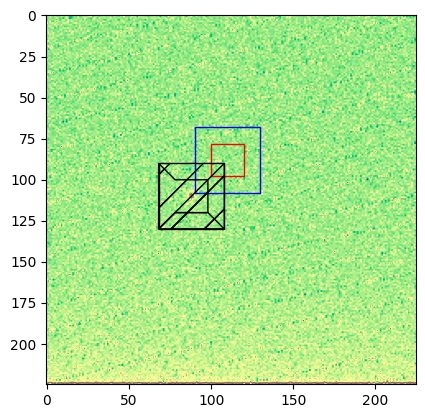

In [27]:
from typing import List
from matplotlib.patches import Rectangle, Polygon
import numpy as np

import matplotlib.pyplot as plt


def add_rectangle(
    ax: plt.Axes,
    center: tuple[int, int],
    width: int,
    height: int,
    edgecolor: str,
    facecolor: str,
):
    """
    Add a rectangle patch to the given axes.

    Parameters:
    - ax: The axes to add the rectangle patch to.
    - center: The center coordinates of the rectangle.
    - width: The width of the rectangle.
    - height: The height of the rectangle.
    - edgecolor: The color of the rectangle's edge.
    - facecolor: The color of the rectangle's face.
    """
    x, y = center
    x_start = x - width // 2
    y_start = y - height // 2
    rect = Rectangle(
        (x_start, y_start), width, height, edgecolor=edgecolor, facecolor=facecolor
    )
    ax.add_patch(rect)


def add_polygon(
    ax: plt.Axes,
    vertices: List[Tuple[int, int]],
    edgecolor: str,
    facecolor: str,
    hatch: str,
):
    """
    Add a polygon patch to the given axes.

    Parameters:
    - ax: The axes to add the polygon patch to.
    - vertices: The vertices of the polygon.
    - edgecolor: The color of the polygon's edge.
    - facecolor: The color of the polygon's face.
    - hatch: The hatch pattern of the polygon.
    """
    polygon = Polygon(
        vertices, closed=True, facecolor=facecolor, edgecolor=edgecolor, hatch=hatch
    )
    ax.add_patch(polygon)


def plot_image_with_rectangles(test_image: np.ndarray, center: Tuple[int, int]):
    """
    Plot the given image with rectangles.

    Parameters:
    - test_image: The image to plot.
    - center: The center coordinates of the rectangles.
    """
    fig, ax = plt.subplots()
    ax.imshow(test_image, cmap="terrain")
    add_rectangle(ax, center, 20, 20, "r", "none")
    add_rectangle(ax, center, 40, 40, "b", "none")

    outer_corners = [
        [center[1] - 20, center[0] - 20],  # Bottom-left
        [center[1] + 20, center[0] - 20],  # Bottom-right
        [center[1] + 20, center[0] + 20],  # Top-right
        [center[1] - 20, center[0] + 20],  # Top-left
    ]

    inner_corners = [
        [center[1] - 10, center[0] - 10],  # Bottom-left
        [center[1] + 10, center[0] - 10],  # Bottom-right
        [center[1] + 10, center[0] + 10],  # Top-right
        [center[1] - 10, center[0] + 10],  # Top-left
    ]

    vertices = [
        outer_corners[0],
        outer_corners[1],
        outer_corners[2],
        outer_corners[3],
        inner_corners[3],
        inner_corners[2],
        inner_corners[1],
        inner_corners[0],
    ]

    add_polygon(ax, vertices[:4], "k", "none", "/")
    add_polygon(ax, vertices[1:5], "k", "none", "/")
    add_polygon(ax, vertices[2:6], "k", "none", "/")
    add_polygon(ax, vertices[3:] + vertices[:1], "k", "none", "/")

    plt.show()


plot_image_with_rectangles(test_image, center)

# Beam Detection Training Data

- Need positive and negative examples
- Positive examples are beams
- Negative examples are not beams

In [8]:
def show_current_image(img):
    try:
        slice_idx = bright_pixel(img, blur_method='gaussian')
    except ValueError as e:
        print(e)
        slice_idx = None
    return slice_idx

def generate_slices(test_image, shape = (30,30)):
    n_slices = test_image.shape[0] // shape[0]
    long_slices = np.array_split(test_image, n_slices, axis=0)
    slices = []
    indices = []
    for j in range(len(long_slices)):
        row_slices = np.array_split(long_slices[j], n_slices, axis=1)
        for i, s in enumerate(row_slices):
            if s.shape != shape:
                s = cv.resize(s, shape)
            slices.append(s)
            indices.append((j, i))
    return indices, slices

def center_slice(test_image: np.ndarray, beam_idx, shape = (32,32)):
    if beam_idx is None:
        raise ValueError("The beam spot has not been located.")

    x, y = beam_idx
    h, w = shape
    # Find the remainder between the beam spot and the center of a h x w slice
    x_rem = x % h
    y_rem = y % w

    # Remove the remainder from the test_image and crop the image
    cropped_image = test_image[x_rem+2:, y_rem+2:]
    indices, slices = generate_slices(cropped_image, shape)
    slice_x = (x - x_rem) // h - 1
    slice_y = (y - y_rem) // w - 1
    beam_slice_idx = (slice_x, slice_y)
    return indices, slices, beam_slice_idx

def show_slices(test_image, beam_idx=None, shape=(32,32), show = False):
    vmin = np.min(test_image)
    vmax = np.max(test_image)

    if beam_idx is None:
        indices, slices = generate_slices(test_image, shape)
    else:
        indices, slices, beam_slice_idx = center_slice(test_image, beam_idx, shape)

    if show:
        fig, ax = plt.subplots(6, 6, figsize=(6.4*8, 4.8*3.5), tight_layout=True)
        ax = ax.flatten()
        for i, s in enumerate(slices):
            try:
                ax[i].imshow(s, cmap='terrain', vmin=vmin, vmax=vmax)
                ax[i].axis('off')
                ax[i].set_title(f"({indices[i][0]},{indices[i][1]})")
            except:
                break
        plt.show()

    if beam_idx is None:
        idx = input("What is the index of the beam spot? (x,y): ")
        beam_slice_idx = tuple(map(int, idx.split(',')))
        plt.close('all')
    # Determine the slice number where the beam spot is located
    return indices, slices, beam_slice_idx


def construct_training_data(slices, indices, beam_slice_idx, df, idx):
    indices, slices = add_rotated(slices, indices)
    width = slices[0].shape[1]
    train = pl.DataFrame(
    {
        'Index': indices,
        'Slice': slices,
        'Theta': df['Theta'][idx],
        'HOS': df['HOS'][idx],
        'Exposure': df['Exposure'][idx],
    },
    schema={
        'Index': pl.Array(pl.Int32,2),
        'Slice': pl.Array(pl.Array(pl.UInt16, width), width),
        'Theta': pl.Float64,
        'HOS': pl.Float64,
        'Exposure': pl.Float64,
    })

    train = train.with_columns(
        pl.when(pl.col('Index') == beam_slice_idx)
        .then(True)
        .otherwise(False)
        .alias('Label')
    )
    return train

def add_rotated(slice, idx):
    # Rotate the slices to be in the same orientation as the training data
    r90 = [cv.rotate(i, cv.ROTATE_90_CLOCKWISE) for i in slice]
    r180 = [cv.rotate(i, cv.ROTATE_180) for i in slice]
    r270 = [cv.rotate(i, cv.ROTATE_90_COUNTERCLOCKWISE) for i in slice]

    # Append the rotated slices to the original slices
    slice.extend(r90)
    slice.extend(r180)
    slice.extend(r270)

    _idx = idx.copy()
    idx.extend(_idx)
    idx.extend(_idx)
    idx.extend(_idx)

    return idx, slice

def package_training_data():
    if os.path.exists("training_data.parquet"):
        return pl.read_parquet("training_data.parquet")

    training_dfs = []
    for i in range(len(df)):
        img = np.frombuffer(df['Image'][i], dtype=np.uint16).reshape(df['Size'][i])
        beam_idx = show_current_image(img)
        show = True if beam_idx is None else False
        indices, slices, beam_slice_idx = show_slices(img, beam_idx, show=show)
        train = construct_training_data(slices, indices, beam_slice_idx, df, i)
        training_dfs.append(train)

    train = pl.concat(training_dfs)
    train.write_parquet("training_data.parquet")
    return train

train = package_training_data()
print(train)
print(df)

shape: (24_740, 6)
┌───────────────┬─────────────────────────────────┬───────┬─────┬──────────┬───────┐
│ Index         ┆ Slice                           ┆ Theta ┆ HOS ┆ Exposure ┆ Label │
│ ---           ┆ ---                             ┆ ---   ┆ --- ┆ ---      ┆ ---   │
│ array[i32, 2] ┆ array[u16, (32, 32)]            ┆ f64   ┆ f64 ┆ f64      ┆ bool  │
╞═══════════════╪═════════════════════════════════╪═══════╪═════╪══════════╪═══════╡
│ [0, 0]        ┆ [[569, 570, … 597], [576, 564,… ┆ 0.0   ┆ 8.8 ┆ 0.001    ┆ false │
│ [0, 1]        ┆ [[574, 566, … 557], [576, 568,… ┆ 0.0   ┆ 8.8 ┆ 0.001    ┆ false │
│ [0, 2]        ┆ [[580, 550, … 553], [566, 559,… ┆ 0.0   ┆ 8.8 ┆ 0.001    ┆ false │
│ [0, 3]        ┆ [[572, 571, … 576], [588, 562,… ┆ 0.0   ┆ 8.8 ┆ 0.001    ┆ false │
│ [0, 4]        ┆ [[546, 566, … 569], [572, 562,… ┆ 0.0   ┆ 8.8 ┆ 0.001    ┆ false │
│ …             ┆ …                               ┆ …     ┆ …   ┆ …        ┆ …     │
│ [5, 1]        ┆ [[613, 588, … 701], [591, 59

# Pytorch Training

In [9]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

# Define the CNN model

class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolve down from a 32x32 image to a 16x16 image with 8 filters
        self.conv1 = Conv2d(1, 8, 3)
        # Convolve down from a 16x16 image to an 8x8 image with 16 filters
        self.conv2 = Conv2d(8, 16, 3)
        # Convolve down from an 8x8 image to a 1x1 image with 32 filters
        self.conv3 = Conv2d(16, 32, 3)
        # Flatten the image
        self.flatten = flatten
        # Fully connected layer
        self.fc1 = Linear(32, 2)
        # Max pooling layer
        self.pool = MaxPool2d(2, 2)
        # Activation function
        self.relu = ReLU()
        # Interpret the output
        self.softmax = LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x, 1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [10]:
# Hyperparameters
import torch


learning_rate = 0.01
batch_size = 36
epochs = 2

training_split = .7
val_split = 1-.7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load the data
